In [1]:
import numpy as np 
from matplotlib import pyplot as plt 
import cartopy

In [10]:
import math
import json
import math

class GeoGridSystem:
    """
    Manages a geographical grid system based on latitude and longitude.

    Approximates cells of a given size in kilometers by calculating
    fixed degree steps. The actual cell size in km will vary with latitude.
    """
    def __init__(self, min_lat, max_lat, min_lon, max_lon, cell_size_km=90.0):
        """
        Initializes the grid system parameters based on the region and desired cell size.

        Args:
            min_lat (float): Minimum latitude of the region.
            max_lat (float): Maximum latitude of the region.
            min_lon (float): Minimum longitude of the region.
            max_lon (float): Maximum longitude of the region.
            cell_size_km (float): Approximate desired size of each cell edge in kilometers.
        """
        if not (min_lat < max_lat and min_lon < max_lon):
            raise ValueError("Invalid region boundaries.")
        if cell_size_km <= 0:
            raise ValueError("Cell size must be positive.")

        self.min_lat = min_lat
        self.max_lat = max_lat
        self.min_lon = min_lon
        self.max_lon = max_lon
        self.cell_size_km = cell_size_km

        # --- Calculate grid parameters ---
        # Approximate km per degree latitude (relatively constant)
        km_per_deg_lat = 111.0

        # Calculate latitude step
        self.delta_lat_deg = cell_size_km / km_per_deg_lat

        # Calculate longitude step based on the central latitude of the region
        center_lat_rad = math.radians((min_lat + max_lat) / 2.0)
        km_per_deg_lon = km_per_deg_lat * math.cos(center_lat_rad)
        if km_per_deg_lon <= 0:
             # Handle edge case near poles where cos(lat) is very small or zero
             # Use a reasonable approximation or fallback based on min latitude
             min_lat_rad = math.radians(min_lat) if min_lat > -90 else math.radians(-89.9) # Avoid pole singularity
             km_per_deg_lon = km_per_deg_lat * math.cos(min_lat_rad)
             if km_per_deg_lon <= 0: # If still zero/negative (extremely close to pole), use a small default
                 km_per_deg_lon = 0.01 # Avoid division by zero


        self.delta_lon_deg = cell_size_km / km_per_deg_lon

        # Calculate number of rows and columns
        self.num_rows = math.ceil((max_lat - min_lat) / self.delta_lat_deg)
        self.num_cols = math.ceil((max_lon - min_lon) / self.delta_lon_deg)

        # Adjust max_lat and max_lon to perfectly align with grid definition
        # This ensures get_cell_id works correctly for points near the max boundaries
        self.adjusted_max_lat = self.min_lat + self.num_rows * self.delta_lat_deg
        self.adjusted_max_lon = self.min_lon + self.num_cols * self.delta_lon_deg


    def get_cell_id(self, lat, lon, as_string=True):
        """
        Determines the grid cell ID (row, col) for a given latitude and longitude.

        Args:
            lat (float): Latitude of the point.
            lon (float): Longitude of the point.

        Returns:
            tuple: A tuple (row_index, col_index) representing the cell ID,
                   or None if the point is outside the defined grid region.
                   Indices are 0-based.
        """
        # Use adjusted max values for boundary checks to include edges correctly
        if not (self.min_lat <= lat < self.adjusted_max_lat and
                self.min_lon <= lon < self.adjusted_max_lon):
             # Special check for points exactly on the max boundary
             if lat == self.adjusted_max_lat and lon == self.adjusted_max_lon:
                 # Assign to the top-rightmost cell
                 return (self.num_rows - 1, self.num_cols - 1)
             if lat == self.adjusted_max_lat and self.min_lon <= lon < self.adjusted_max_lon:
                  # Assign points on the top boundary (excluding top-right corner) to the row below
                 row_index = self.num_rows - 1
                 col_index = math.floor((lon - self.min_lon) / self.delta_lon_deg)
                 # Ensure col_index is within valid range due to potential floating point issues
                 col_index = min(max(col_index, 0), self.num_cols - 1)
                 return (row_index, int(col_index))
             if lon == self.adjusted_max_lon and self.min_lat <= lat < self.adjusted_max_lat:
                  # Assign points on the right boundary (excluding top-right corner) to the column to the left
                 col_index = self.num_cols - 1
                 row_index = math.floor((lat - self.min_lat) / self.delta_lat_deg)
                 # Ensure row_index is within valid range
                 row_index = min(max(row_index, 0), self.num_rows - 1)
                 return (int(row_index), col_index)

             return None # Outside the grid

        row_index = math.floor((lat - self.min_lat) / self.delta_lat_deg)
        col_index = math.floor((lon - self.min_lon) / self.delta_lon_deg)

        # Ensure indices are within bounds due to potential floating point inaccuracies at edges
        row_index = min(max(row_index, 0), self.num_rows - 1)
        col_index = min(max(col_index, 0), self.num_cols - 1)

        if as_string:
            return f"{row_index:02d}{col_index:02d}"
        else:
            return (int(row_index), int(col_index))

    def get_cell_bounds(self, cell_id):
        """
        Calculates the latitude and longitude bounds for a given cell ID.

        Args:
            cell_id (tuple): The cell ID tuple (row_index, col_index) or string "xxyy"

        Returns:
            dict: A dictionary containing the bounds:
                  {'min_lat': ..., 'max_lat': ..., 'min_lon': ..., 'max_lon': ...}
                  Returns None if the cell_id is invalid.
        """
        if isinstance(cell_id, str):
            cell_id = (int(cell_id[:2]), int(cell_id[2:]))
        row_index, col_index = cell_id

        if not (0 <= row_index < self.num_rows and 0 <= col_index < self.num_cols):
            return None # Invalid cell ID

        cell_min_lat = self.min_lat + row_index * self.delta_lat_deg
        cell_max_lat = self.min_lat + (row_index + 1) * self.delta_lat_deg
        cell_min_lon = self.min_lon + col_index * self.delta_lon_deg
        cell_max_lon = self.min_lon + (col_index + 1) * self.delta_lon_deg

        # Ensure bounds do not exceed the original max limits slightly due to float math
        # Use the adjusted max values here for consistency with get_cell_id boundary logic
        cell_max_lat = min(cell_max_lat, self.adjusted_max_lat)
        cell_max_lon = min(cell_max_lon, self.adjusted_max_lon)


        return {
            'min_lat': cell_min_lat,
            'max_lat': cell_max_lat,
            'min_lon': cell_min_lon,
            'max_lon': cell_max_lon,
        }

    def get_config(self):
        """Returns the configuration parameters of the grid."""
        return {
            'min_lat': self.min_lat,
            'max_lat': self.max_lat,
            'min_lon': self.min_lon,
            'max_lon': self.max_lon,
            'cell_size_km': self.cell_size_km,
            'delta_lat_deg': self.delta_lat_deg,
            'delta_lon_deg': self.delta_lon_deg,
            'num_rows': self.num_rows,
            'num_cols': self.num_cols,
            'adjusted_max_lat': self.adjusted_max_lat,
            'adjusted_max_lon': self.adjusted_max_lon
        }

    def save_config(self, filepath):
        """
        Saves the grid configuration parameters to a JSON file.
        This is efficient as it doesn't store bounds for every cell.
        """
        with open(filepath, 'w') as f:
            json.dump(self.get_config(), f, indent=4)

    @classmethod
    def load_config(cls, filepath):
        """
        Loads grid configuration from a JSON file and creates a GeoGridSystem instance.
        """
        with open(filepath, 'r') as f:
            config = json.load(f)

        # Create instance without calling __init__ directly to avoid recalculating
        instance = cls.__new__(cls)

        # Manually set attributes from loaded config
        instance.min_lat = config['min_lat']
        instance.max_lat = config['max_lat']
        instance.min_lon = config['min_lon']
        instance.max_lon = config['max_lon']
        instance.cell_size_km = config['cell_size_km']
        instance.delta_lat_deg = config['delta_lat_deg']
        instance.delta_lon_deg = config['delta_lon_deg']
        instance.num_rows = config['num_rows']
        instance.num_cols = config['num_cols']
        instance.adjusted_max_lat = config.get('adjusted_max_lat', instance.min_lat + instance.num_rows * instance.delta_lat_deg) # Backwards compatibility
        instance.adjusted_max_lon = config.get('adjusted_max_lon', instance.min_lon + instance.num_cols * instance.delta_lon_deg) # Backwards compatibility


        return instance
    
    def plot_grid(self, ax=None, cell_ids=None, plot_labels=False, grid_color='blue', 
              grid_linewidth=0.5, background='natural_earth', figsize=(12, 8)):
        """
        Plots the grid cells on a map using Cartopy.
        
        Args:
            ax (GeoAxes, optional): Existing Cartopy GeoAxes. If None, a new figure and axes are created.
            cell_ids (list, optional): List of specific cell IDs to highlight. If None, all cells are shown.
            plot_labels (bool): Whether to plot cell ID labels at the center of each cell.
            grid_color (str): Color of the grid lines.
            grid_linewidth (float): Width of the grid lines.
            background (str): Background type for the map ('stock_img', 'natural_earth', None).
            figsize (tuple): Figure size in inches if creating a new figure.
            
        Returns:
            matplotlib.axes.Axes: The axes on which the grid was plotted.
        """
        import cartopy.crs as ccrs
        import cartopy.feature as cfeature
        from matplotlib import pyplot as plt
        
        # Create new figure and axes if none provided
        if ax is None:
            plt.figure(figsize=figsize)
            ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=10.0, central_latitude=50.0, standard_parallels=(35.0, 65.0)))
            
            # Add background
            if background == 'stock_img':
                ax.stock_img()
            elif background == 'natural_earth':
                # ax.add_feature(cfeature.LAND)
                # ax.add_feature(cfeature.OCEAN)
                ax.add_feature(cfeature.COASTLINE)
                ax.add_feature(cfeature.BORDERS, linestyle=':')
            
            # Set extent to show the grid area with some padding
            padding = 2  # degrees
            ax.set_extent([self.min_lon - padding, self.adjusted_max_lon + padding, 
                        self.min_lat - padding, self.adjusted_max_lat + padding])
        
        # Determine which cells to plot
        if cell_ids is None:
            # Plot all cells
            rows = range(self.num_rows)
            cols = range(self.num_cols)
        else:
            # Plot only specified cells
            rows = [cell_id[0] for cell_id in cell_ids]
            cols = [cell_id[1] for cell_id in cell_ids]
            
        # Draw grid lines
        for row in range(self.num_rows + 1):
            lat = self.min_lat + row * self.delta_lat_deg
            ax.plot([self.min_lon, self.adjusted_max_lon], [lat, lat], 
                    color=grid_color, linewidth=grid_linewidth, transform=ccrs.PlateCarree())
        
        for col in range(self.num_cols + 1):
            lon = self.min_lon + col * self.delta_lon_deg
            ax.plot([lon, lon], [self.min_lat, self.adjusted_max_lat], 
                    color=grid_color, linewidth=grid_linewidth, transform=ccrs.PlateCarree())
        
        # Highlight specific cells if requested
        if cell_ids is not None:
            for cell_id in cell_ids:
                row, col = cell_id
                bounds = self.get_cell_bounds(cell_id)
                if bounds:
                    # Draw rectangle for the cell
                    from matplotlib.patches import Rectangle
                    rect = Rectangle((bounds['min_lon'], bounds['min_lat']), 
                                    self.delta_lon_deg, self.delta_lat_deg, 
                                    fill=True, alpha=0.3, color='red', 
                                    transform=ccrs.PlateCarree())
                    ax.add_patch(rect)
        
        # Add labels if requested
        if plot_labels:
            for row in range(self.num_rows):
                for col in range(self.num_cols):
                    if cell_ids is None or (row, col) in cell_ids:
                        bounds = self.get_cell_bounds((row, col))
                        center_lat = (bounds['min_lat'] + bounds['max_lat']) / 2
                        center_lon = (bounds['min_lon'] + bounds['max_lon']) / 2
                        ax.text(center_lon, center_lat, f"({row},{col})", 
                            horizontalalignment='center', verticalalignment='center',
                            transform=ccrs.PlateCarree(), fontsize=8)
        
        # Add gridlines with lat/lon labels
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                        linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        
        return ax

    def __str__(self):
        return (f"GeoGridSystem(Region: Lat[{self.min_lat:.2f}, {self.max_lat:.2f}], "
                f"Lon[{self.min_lon:.2f}, {self.max_lon:.2f}], "
                f"CellSize: ~{self.cell_size_km}km, GridDims: {self.num_rows}x{self.num_cols})")


In [11]:
# --- Example Usage ---

# Define a region (e.g., roughly contiguous US)
min_lat_us = 30.0
max_lat_us = 72.0
min_lon_us = -15.0
max_lon_us = 40.0

try:
    # 1. Create the grid system object
    grid_system = GeoGridSystem(min_lat_us, max_lat_us, min_lon_us, max_lon_us, cell_size_km=90.0)
    print(f"Created Grid System: {grid_system}")
    print(f"Delta Lat (deg): {grid_system.delta_lat_deg:.4f}")
    print(f"Delta Lon (deg): {grid_system.delta_lon_deg:.4f}")


    # 2. Get cell ID for a specific point (Paris CDG)
    lat_point = 49.0034
    lon_point = 2.5573
    cell_id = grid_system.get_cell_id(lat_point, lon_point)
    print(f"\nCell ID for ({lat_point}, {lon_point}): {cell_id}")

    # 3. Get bounds for that cell ID
    if cell_id:
        bounds = grid_system.get_cell_bounds(cell_id)
        print(f"Bounds for Cell ID {cell_id}: {bounds}")


    # 4. Save the grid configuration (parameters) to a file
    config_filepath = 'geo_grid_config.json'
    grid_system.save_config(config_filepath)
    print(f"\nGrid configuration saved to {config_filepath}")

    # 5. Load the configuration from the file
    loaded_grid_system = GeoGridSystem.load_config(config_filepath)
    print(f"\nLoaded Grid System: {loaded_grid_system}")

    # Verify loaded system works
    cell_id_loaded = loaded_grid_system.get_cell_id(lat_point, lon_point)
    print(f"Cell ID from loaded system for ({lat_point}, {lon_point}): {cell_id_loaded}")
    assert cell_id == cell_id_loaded


except ValueError as e:
    print(f"Error: {e}")
except FileNotFoundError:
    print(f"Error: Config file not found for loading.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


Created Grid System: GeoGridSystem(Region: Lat[30.00, 72.00], Lon[-15.00, 40.00], CellSize: ~90.0km, GridDims: 52x43)
Delta Lat (deg): 0.8108
Delta Lon (deg): 1.2884

Cell ID for (49.0034, 2.5573): 2313
Bounds for Cell ID 2313: {'min_lat': 48.648648648648646, 'max_lat': 49.45945945945946, 'min_lon': 1.7490847117741168, 'max_lon': 3.0374758434490516}

Grid configuration saved to geo_grid_config.json

Loaded Grid System: GeoGridSystem(Region: Lat[30.00, 72.00], Lon[-15.00, 40.00], CellSize: ~90.0km, GridDims: 52x43)
Cell ID from loaded system for (49.0034, 2.5573): 2313


<Figure size 1200x800 with 0 Axes>

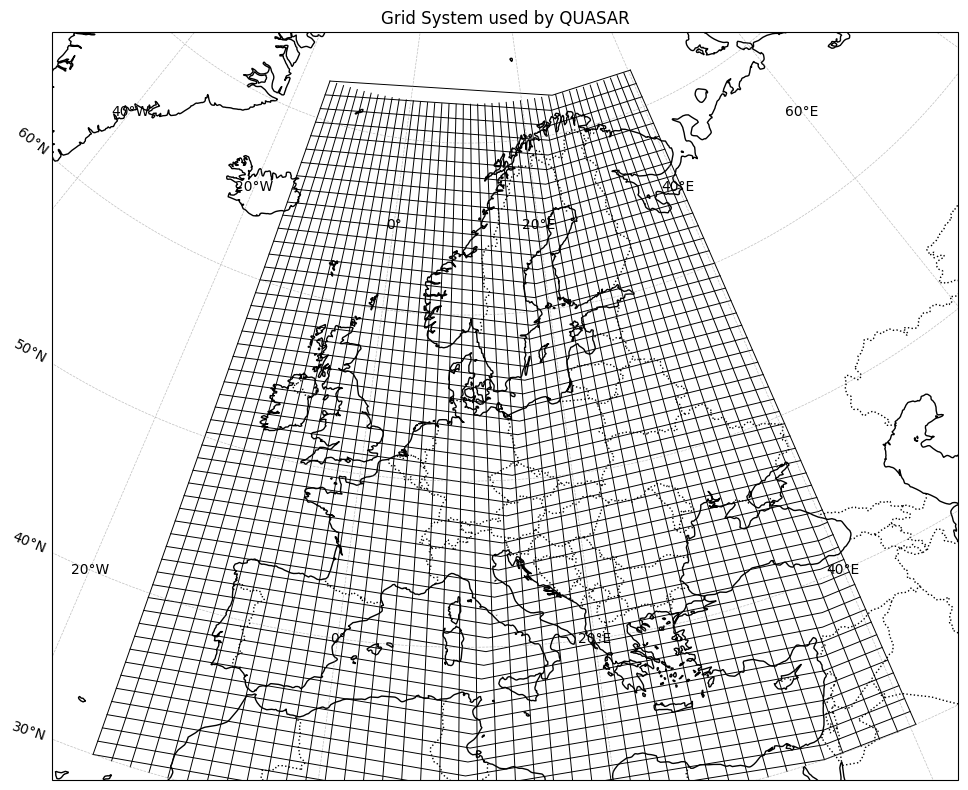

In [12]:
# Create plot with natural earth features
plt.figure(figsize=(12, 8))
ax = grid_system.plot_grid(background='natural_earth', grid_color='black', grid_linewidth=0.7)
plt.title('Grid System used by QUASAR')
plt.tight_layout()
plt.show()